In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import random
from scipy import ndimage

from tensorflow import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, GlobalAveragePooling3D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.metrics import AUC, F1Score
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.utils import Sequence

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("maximnaddaf/ct-multi-modal-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [3]:
def count_directories(path):
    # List all items in the directory and filter for directories
    return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])


non_healthy = "/kaggle/input/Processed_CT/CT-23"
healthy = "/kaggle/input/Processed_CT/CT-0"

print(f"Number of directories in non healthy: {count_directories(non_healthy)}")
print(f"Number of directories in healthy: {count_directories(healthy)}")

Number of directories in non healthy: 172
Number of directories in healthy: 172


In [4]:
# Function to load a .nii.gz file
def load_nii(file_path):
    return nib.load(file_path).get_fdata()


def rotate(volume):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume



class MultiModalDataset(Sequence):
    def __init__(self, patient_dirs, labels, batch_size, fold, shuffle=True):
        self.patient_dirs = patient_dirs
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.fold = fold
        self.indices = np.arange(len(self.patient_dirs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.patient_dirs) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_patient_dirs = [self.patient_dirs[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        # Load modalities
        X = self.__load_modalities(batch_patient_dirs)
        y = np.array(batch_labels)

        X = tuple(tf.convert_to_tensor(x, dtype=tf.float32) for x in X)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_modalities(self, patient_dirs):
        modalities = {'split_1': [], 'split_2': []}

        for patient_dir in patient_dirs:
            patient_name = os.path.basename(patient_dir)

            split_1_path = os.path.join(patient_dir, 'split_part_1.nii')
            split_2_path = os.path.join(patient_dir, 'split_part_2.nii')

            # Load each modality
            split_1 = load_nii(split_1_path)
            split_2 = load_nii(split_2_path)

            if (self.fold == "train"):
                split_1_augmented = rotate(split_1)
                split_2_augmented = rotate(split_2)

                modalities['split_1'].append(split_1_augmented)
                modalities['split_2'].append(split_2_augmented)

            elif (self.fold == "test"):
                modalities['split_1'].append(split_1)
                modalities['split_2'].append(split_2)


        # Stack the modalities for each patient along the first axis (batch axis)
        X = [
            np.array(modalities['split_1']),
            np.array(modalities['split_2']),
        ]

        return X

# Define the paths to your directories
healthy_dir = healthy
non_healthy_dir = non_healthy

# List all patient directories (assuming each patient has a folder in each group)
healthy_patients = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if os.path.isdir(os.path.join(healthy_dir, f))]
non_healthy_patients = [os.path.join(non_healthy_dir, f) for f in os.listdir(non_healthy_dir) if os.path.isdir(os.path.join(non_healthy_dir, f))]

# Initialize lists to hold the data and labels
patient_dirs = []  # Will hold paths to the patient directories
labels = []  # Will hold the labels (0 for healthy, 1 for non-healthy)

# Load the data from healthy patients
for patient in healthy_patients:
    patient_dirs.append(patient)
    labels.append(0)  # Label 0 for healthy

# Load the data from non-healthy patients
for patient in non_healthy_patients:
    patient_dirs.append(patient)
    labels.append(1)  # Label 1 for non-healthy

# Convert to NumPy arrays
patient_dirs = np.array(patient_dirs)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(len(patient_dirs))
np.random.shuffle(indices)

patient_dirs = patient_dirs[indices]
labels = labels[indices]

# Split the data into training and testing sets (80/20)
patient_dirs_train, patient_dirs_test, labels_train, labels_test = train_test_split(patient_dirs, labels, test_size=0.2, random_state=42)

# Create the training and testing dataset objects
train_dataset = MultiModalDataset(patient_dirs_train, labels_train, batch_size=2, fold="train", shuffle=True)
test_dataset = MultiModalDataset(patient_dirs_test, labels_test, batch_size=2, fold="test", shuffle=False)

# Check the length of the datasets
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Test Dataset Length: {len(test_dataset)}")
print(f"Labels Dataset Length: {len(labels)}")

print("\n")

X, y = train_dataset[0]

for modality, data in zip(['split_1', 'split_2'], X):
    print(f"Shape of {modality} modality: {data.shape}")

print(f"label: {y}")


Train Dataset Length: 137
Test Dataset Length: 34
Labels Dataset Length: 344


Shape of split_1 modality: (2, 224, 224, 25)
Shape of split_2 modality: (2, 224, 224, 25)
label: [1 0]


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 1


Number of scans: 2
Dimension of CT scan: (224, 224, 25)
label= 1




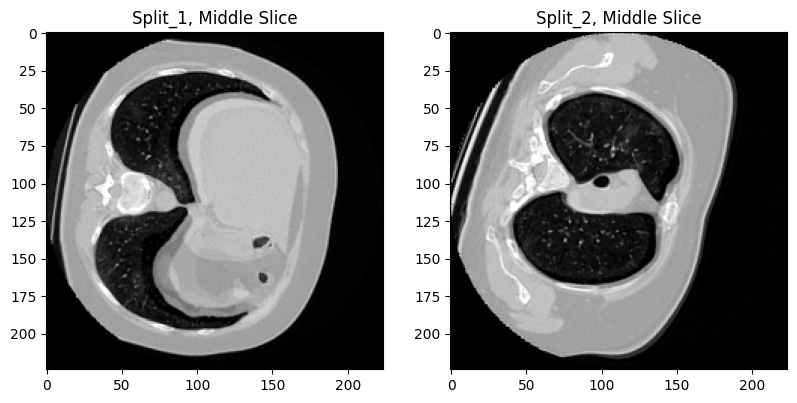

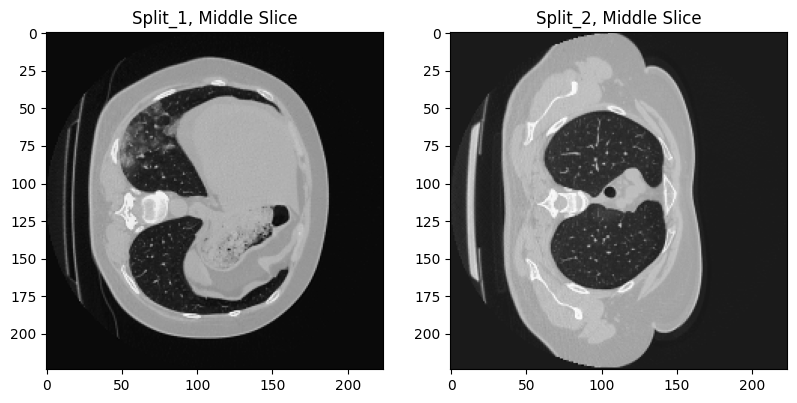

In [5]:
def plot_scans_from_dataset(dataset):

    fig = plt.figure(figsize=(20,8))

    for i in range(1):
        scans, label = dataset[i]
        print("Number of scans:", len(scans))
        print("Dimension of CT scan:", scans[0][0].shape)
        print("label=",label[i])
        print("\n")

        ax1 = plt.subplot(1,4,1)
        ax1.imshow(scans[0][0][:,:, scans[0][0].shape[2] // 2], cmap="gray")
        ax1.set_title("Split_1, Middle Slice")
        ax2 = plt.subplot(1,4,2)
        ax2.imshow(scans[1][0][:,:, scans[1][0].shape[2] // 2], cmap="gray")
        ax2.set_title("Split_2, Middle Slice")

plot_scans_from_dataset(train_dataset)
plot_scans_from_dataset(test_dataset)

In [6]:
def get_model(inputs):
    """Build a 3D convolutional neural network model."""

    x = Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Conv3D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    return x

In [7]:
split_1_input = Input(shape=(224, 224, 25, 1))
split_1_model = get_model(split_1_input)

split_2_input = Input(shape=(224, 224, 25, 1))
split_2_model = get_model(split_2_input)


# Concat models and add final block
x = concatenate([split_1_model, split_2_model])

x = GlobalAveragePooling3D()(x)
x = Dense(units=700, activation="relu")(x)
x = Dropout(0.3)(x)

output_layer = Dense(units=1, activation="sigmoid")(x)

# Final model
cnn_model = Model(inputs=[split_1_input, split_2_input], outputs=[output_layer], name="multi3dcnn")

# f1score = tf.keras.metrics.F1Score(average="weighted",threshold=0.5)

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=False
)

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 20, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model_save = ModelCheckpoint(f'3d_image_classification.keras',
                             save_best_only = True,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)

# Compile final model
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  metrics=["accuracy", "AUC"])

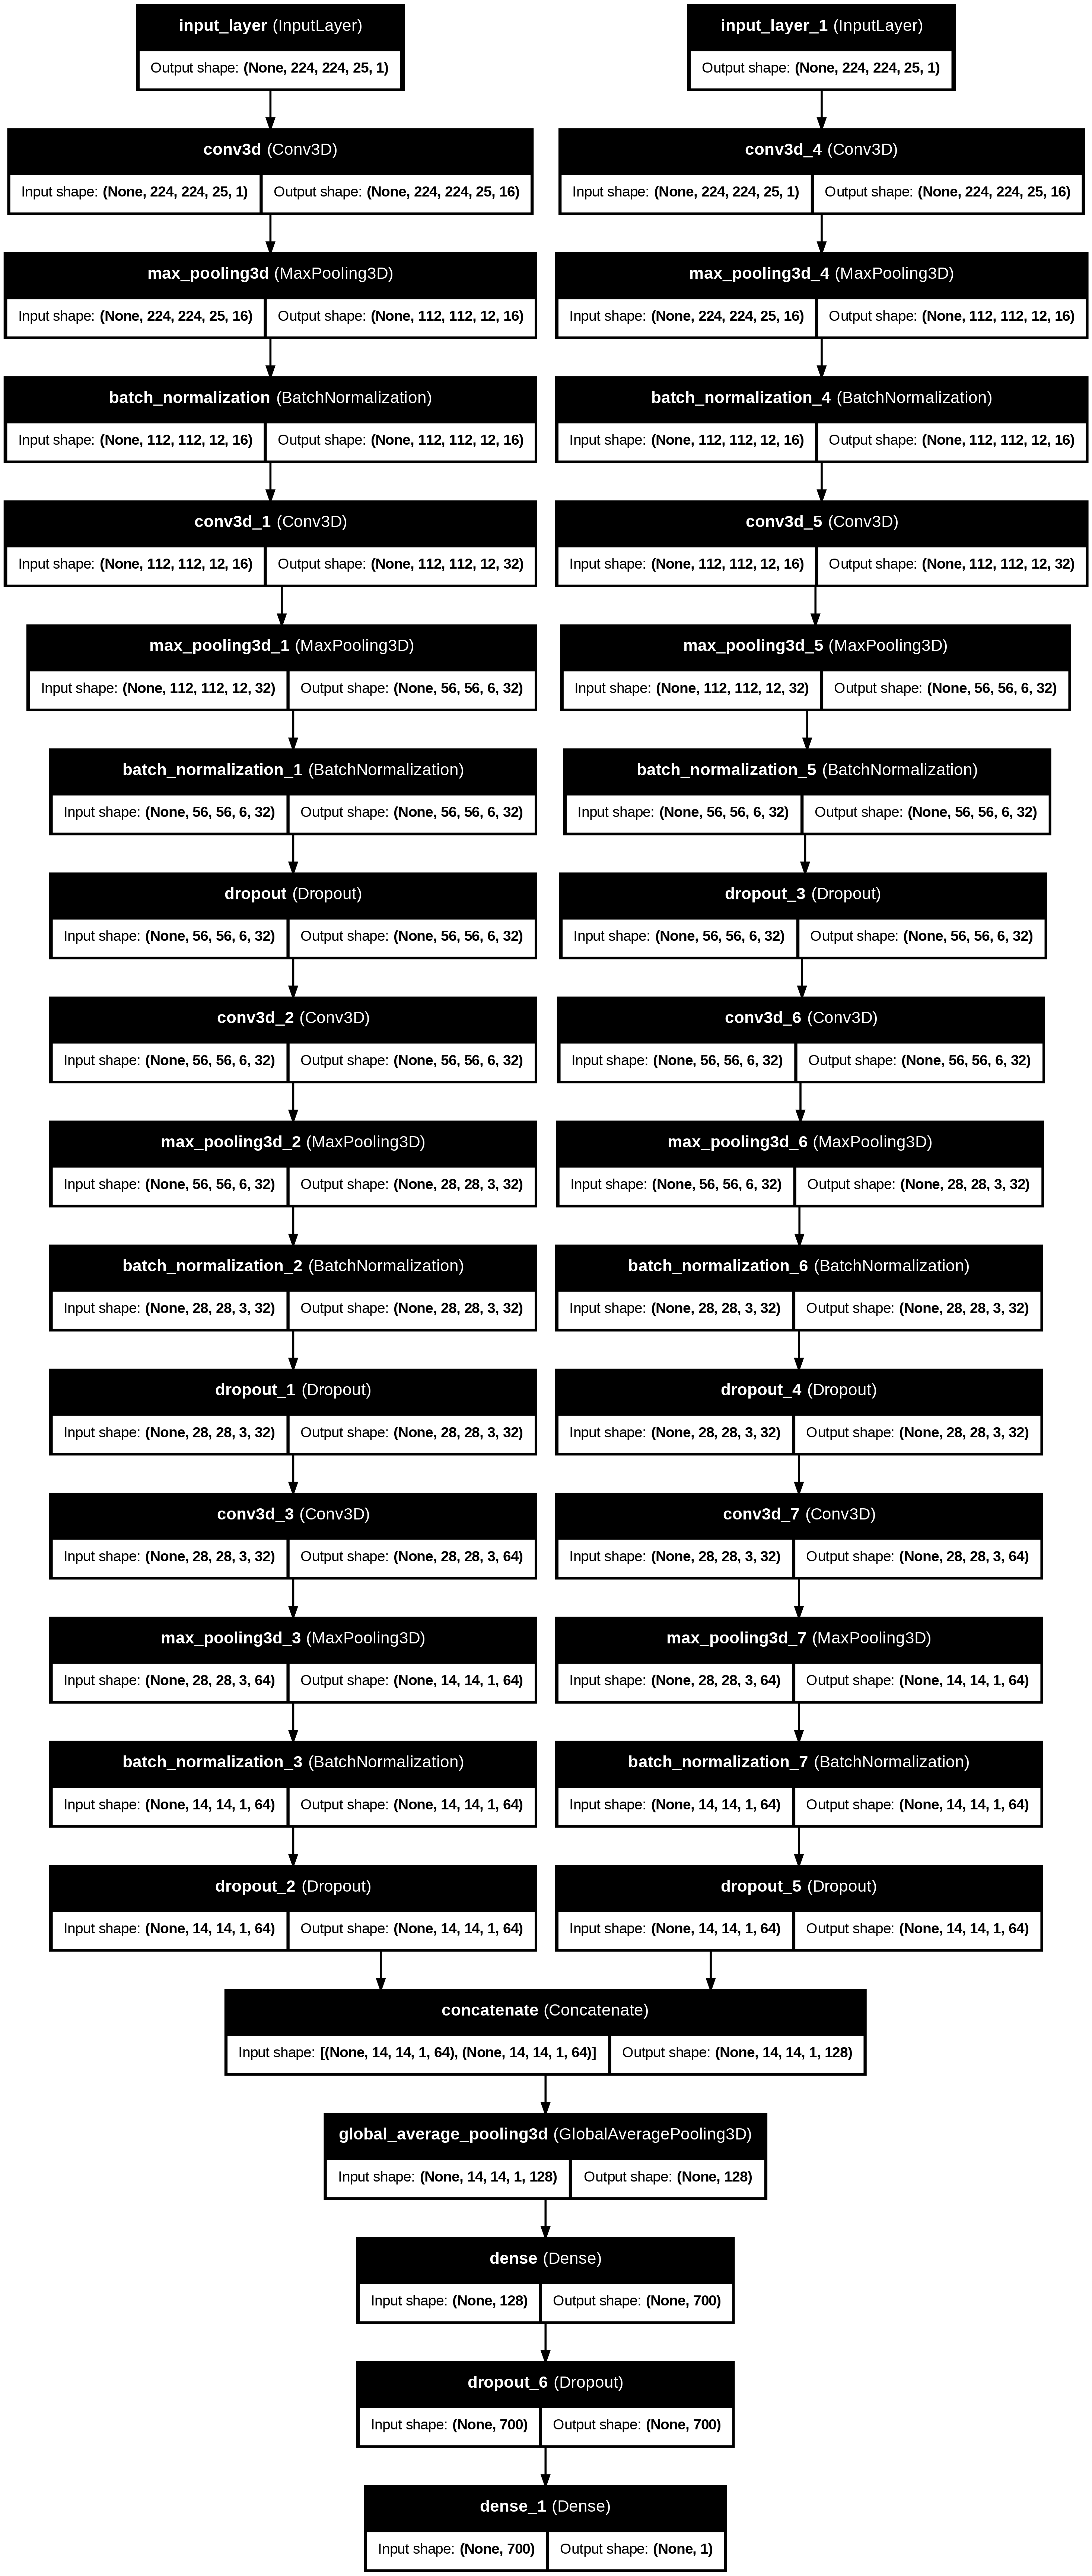

In [8]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

In [9]:
cnn_model.summary()

Model: "multi3dcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 25,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 224, 224, 25,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 224, 224, 25,   │            448 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_4 (Conv3D)         │ (None, 224, 224, 25,   │            448 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 112, 112, 12,   │              0 │ conv3d[0][0]           │
│ (MaxPooling3D)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 112, 112, 12,   │              0 │ conv3d_4[0][0]         │
│ (MaxPooling3D)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 12,   │             64 │ max_pooling3d[0][0]    │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 112, 112, 12,   │             64 │ max_pooling3d_4[0][0]  │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 112, 112, 12,   │         13,856 │ batch_normalization[0… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_5 (Conv3D)         │ (None, 112, 112, 12,   │         13,856 │ batch_normalization_4… │
│                           │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 56, 56, 6, 32)  │              0 │ conv3d_1[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 56, 56, 6, 32)  │              0 │ conv3d_5[0][0]         │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 6, 32)  │            128 │ max_pooling3d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 286,841 (1.09 MB)

 Trainable params: 286,265 (1.09 MB)

 Non-trainable params: 576 (2.25 KB)

In [10]:
history = cnn_model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[model_save, early_stop])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - AUC: 0.5345 - accuracy: 0.4965 - loss: 0.6978

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.69442, saving model to 3d_image_classification.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 145s 846ms/step - AUC: 0.5348 - accuracy: 0.4968 - loss: 0.6978 - val_AUC: 0.6940 - val_accuracy: 0.5588 - val_loss: 0.6944
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - AUC: 0.5799 - accuracy: 0.5808 - loss: 0.6821
Epoch 2: val_loss did not improve from 0.69442
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 707ms/step - AUC: 0.5804 - accuracy: 0.5809 - loss: 0.6819 - val_AUC: 0.5658 - val_accuracy: 0.5441 - val_loss: 0.7851
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - AUC: 0.6892 - accuracy: 0.6072 - loss: 0.6470
Epoch 3: val_loss did not improve from 0.69442
137/137 ━━━━━━━━━━━━━━━━━━━━ 102s 705ms/step - AUC: 0.6888 - accuracy: 0.6071 - loss: 0.6472 - val_AUC: 0.7232 - val_accuracy: 0.5000 - val_loss: 0.7748
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - AUC: 0.6560 - accuracy: 0.6175 - loss: 0.6522
Epoch 4: val_loss did not improve from 0.69442

In [11]:
cnn_model.evaluate(test_dataset)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - AUC: 0.8940 - accuracy: 0.8527 - loss: 0.3294


[0.2880825400352478, 0.8823529481887817, 0.9546642899513245]

In [12]:
cnn_model.save('/kaggle/working/3d_image_classification.keras')
cnn_model_improved = load_model('/kaggle/working/3d_image_classification.keras')